# Initialization

Here we initialized our program and test if we have all the neccessary dependcies needed to run the program.

## Presequisite:

Ensure all dependencies are available

```shell
python3 -m pip install jupyter pandas matplotlib sklearn scipy
```


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

print("[INFO] Import Successfully")

test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")
train_shape = train.shape

print("[DEBUG] train_shape: {0}".format(train_shape))

[INFO] Import Successfully
[DEBUG] train_shape: (891, 12)


## Get familiarize with the data

Next, we will review what is available in the provided csv files

In [2]:
print("First 5 rows of train.csv:")
train.head()

# print("Last 5 rows of train.csv:")
# train.tail()

First 5 rows of train.csv:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can also use graph to plot out the data and understand it better.

Here we plot a chart to understand the relationship between Gender(Sex) of passengers and survivability.

Vertical axis should represent the mean of survivability, ranging from 0->1 with the higher the number, the more likely person with that attribute to survive the incident.

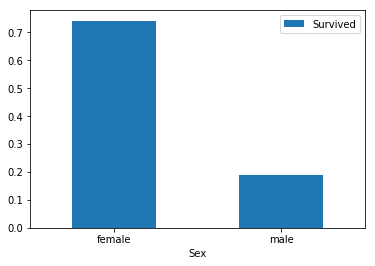

In [3]:
import matplotlib.pyplot as plt

gender_pivot = train.pivot_table(index="Sex", values="Survived")
gender_pivot.plot.bar()
plt.xticks(rotation='0')
plt.show()

Here we make the ploting generic so we can try out with different Columns in the provided train data table.

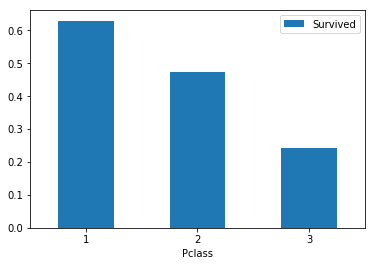

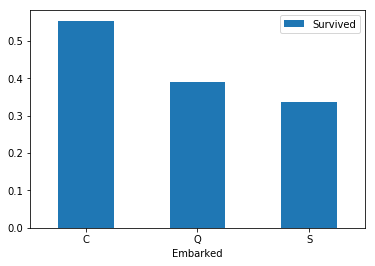

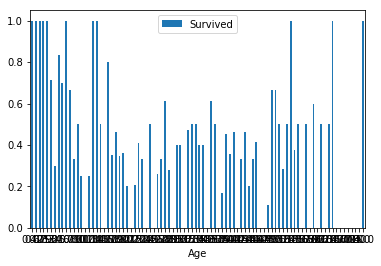

In [4]:
def plot_survival(idx,df):
    pivot = df.pivot_table(index=idx, values="Survived")
    pivot.plot.bar()
    plt.xticks(rotation='0')
    plt.show()
    
plot_survival("Pclass", train)
plot_survival("Embarked", train)
plot_survival("Age", train)

## Prepare Data

As we graphed out Age column, we can see that data are very messy and does not contribute much to initial analysis.

Here we will explore one of the way we can make it better: Converting Ages into appropriate Group Labels. Then use these Labels to do analysis instead.

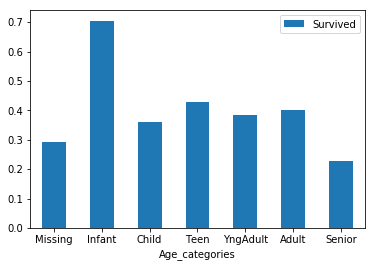

In [5]:
def process_age(df, cut_points, label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(
        df["Age"],
        cut_points,
        labels=label_names
    )
    return df

CUT_POINTS = [-1, 0, 5, 12, 18, 35, 60, 100]
AGE_LABELS = ["Missing", "Infant",
              "Child", "Teen",
              "YngAdult", "Adult", "Senior"]

train = process_age(train, CUT_POINTS, AGE_LABELS)
test = process_age(test, CUT_POINTS, AGE_LABELS)

plot_survival("Age_categories", train)

This technique is also known as **Slicing** or **Slicing Subsets**.

As we use data to analytic, we sometimes encountered data which are not labeled, or not organized, or quantifiable. These techniques will help us prepare our data in a way that we can easily quantify and put them into a mathematical model.

Next, we will learn how to decouple relationship between data that is hard to quantify.

A good example here is `Pclass` column.

In [6]:
train["Pclass"].unique()

array([3, 1, 2])

As observed, Pclass column could be either value 1, 2 or 3.

However as we can related in realife, these do not mean that a Pclass with value 2 should `weighted` **twice** as much compare to a Pclass with value 1.

In this situation, [1,2,3] are just labels, without numeric relationship.

A solution for this problem would be to transcribe `Pclass` column into different boolean columns `Pclass_1`, `Pclass_2` and `Pclass_3`.
This way each label will be treated separately without relating to each other.

So lets do just that.

In [7]:
def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, dummies], axis=1)
    return df

train = create_dummies(train, "Pclass")

And we will be doing the same for columns `Sex` and `Age_categories` (which we derived from Age earlier by **Slicing Subsets**)

In [8]:
train = create_dummies(train, "Sex")
train = create_dummies(train, "Age_categories")

And be cause we need to work with our test data later on, we will be applying the same transformation to `test` just as we did for `train`

In [9]:
test = create_dummies(test, "Pclass")
test = create_dummies(test, "Sex")
test = create_dummies(test, "Age_categories")

## Creating First Machine Learning Model

Now that our data is ready to be trained into model.
We will begin by reviewing what we have so far

In [10]:
print(train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked' 'Age_categories' 'Pclass_1' 'Pclass_2'
 'Pclass_3' 'Sex_female' 'Sex_male' 'Age_categories_Missing'
 'Age_categories_Infant' 'Age_categories_Child' 'Age_categories_Teen'
 'Age_categories_YngAdult' 'Age_categories_Adult' 'Age_categories_Senior']


Our current target of this tutorial is to use `Pclass`, `Sex` and `Age` as the categories of assessment for passenger `Survival` rate.

Through out the previous steps, here are the list of columns we are interested in

In [11]:
columns = [
    'Pclass_1', 'Pclass_2', 'Pclass_3',
    
    'Sex_female', 'Sex_male',
    
    'Age_categories_Missing',
    'Age_categories_Infant',
    'Age_categories_Child', 
    'Age_categories_Teen',
    'Age_categories_YngAdult', 
    'Age_categories_Adult',
    'Age_categories_Senior'
]

Knowing that, we shall start with [**Logistic Regression**](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(train[columns], train['Survived'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Here we use LogReg to fit the data from our interested columns into the labels that is corresponded with those data.

In this case, the label is `Survived`.

Meaning, given these data of `true` and `false`, we expect our model to conclude something close to the given `Survived` result.

Simple ain't it? :ok_hand:

## Verify our result

tbd